# Notebook error analysis 

## Manual labels of the sampled errors for each cluster

in terms of bug types and root causes

In [20]:
# import importlib
# importlib.reload(config)
# import config

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


# 1. Prepare statistics

In [1]:
import pandas as pd
import config
import numpy as np
#what have been labeled
df_mlerr_labels = pd.read_csv(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled2_0.csv'), 
                              header=0, 
                              encoding='ISO-8859-1',
                              keep_default_na=False) # to keep "n/a" values
df_mlerr_labeled_clusters = df_mlerr_labels.pregroup_cluster.unique()
df_mlerr_label_config = pd.read_csv(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled2_Config.csv'),
                                    header=0,
                                    encoding='ISO-8859-1',
                                    keep_default_na=False)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


In [2]:
# # need to take care of n/a in df_mlerr_label_config (label_refined_exp_type)!!!!!!
# # it means the same as the enames

# df_mlerr_labels['label_refined_exp_type'] = np.where(df_mlerr_labels['label_refined_exp_type'] == 'n/a', 
#                                                      df_mlerr_labels['ename'], 
#                                                      df_mlerr_labels['label_refined_exp_type'])
# real_refined_exp_types = set(df_mlerr_label_config.label_refined_exp_type).union(set(df_mlerr_labels['label_refined_exp_type'].unique()))
# real_refined_exp_types.remove("n/a")
# real_refined_exp_types=list(real_refined_exp_types)
# for _ in range(len(df_mlerr_label_config)-len(real_refined_exp_types)):
#     real_refined_exp_types.append(np.nan)
# for _ in range(len(real_refined_exp_types)-len(df_mlerr_label_config)):
#     df_mlerr_label_config.loc[len(df_mlerr_label_config)] = pd.Series(dtype='float64')

# df_mlerr_label_config['label_refined_exp_type'] = list(real_refined_exp_types)

In [3]:
df_mlerr_labels_g = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
assert(len(df_mlerr_labels_g)+len(df_mlerr_labels_k)==len(df_mlerr_labels))

In [4]:
# we do not need to calculate statistics based on clusters and generalize it to the whole population
# because now we sample over the whole population
# so whatever we get from the sample now represent the whole population

## selected_cluster_sizes = pd.read_excel(config.path_default.joinpath("data_dedup_cluster/df_err_processed_pregroup_cluster_sizes.xlsx"))

In [5]:
import pickle

# summarize the statistics
def statistics_labels(df_mlerr_label_config, selected_cluster_sizes_all, selected_cluster_sizes_group, df_mlerr_labels):
    cluster_res = {}
    for label_key in df_mlerr_label_config:
        cluster_res[label_key] = {}

    for index, row in selected_cluster_sizes_all.iterrows():
        cluster_id = row.pregroup_cluster
        cluster_size_group = selected_cluster_sizes_group[selected_cluster_sizes_group.pregroup_cluster==cluster_id]
        if len(cluster_size_group)>0:
            cluster_size = cluster_size_group.iloc[0].cluster_size

            cluster_errors = df_mlerr_labels[df_mlerr_labels.pregroup_cluster == cluster_id]
            for label_key in df_mlerr_label_config:
                for label_key_option in df_mlerr_label_config[label_key].dropna():
                    cluster_label_key_option_size = sum(cluster_errors[label_key]==label_key_option)
                    if label_key_option not in cluster_res[label_key]:
                        cluster_res[label_key][label_key_option] = {}
                    cluster_res[label_key][label_key_option][cluster_id] = (cluster_label_key_option_size, len(cluster_errors), cluster_size)
        else: # no errors in this cluster for the target group/source
            pass
#             for label_key in df_mlerr_label_config:
#                 for label_key_option in df_mlerr_label_config[label_key].dropna():
#                     if label_key_option not in cluster_res[label_key]:
#                         cluster_res[label_key][label_key_option] = {}
#                     cluster_res[label_key][label_key_option][cluster_id] = (0, 0, 0)
    return cluster_res

def save_statistics(save_path, cluster_res):
    with open(save_path, 'wb') as handle:
        pickle.dump(cluster_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
cluster_res_all = statistics_labels(df_mlerr_label_config, selected_cluster_sizes, selected_cluster_sizes, df_mlerr_labels)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_all.pickle"), cluster_res_all)

In [8]:
cluster_res_g = statistics_labels(df_mlerr_label_config, selected_cluster_sizes, selected_cluster_sizes_g, df_mlerr_labels_g)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_g.pickle"), cluster_res_g)

cluster_res_k = statistics_labels(df_mlerr_label_config, selected_cluster_sizes, selected_cluster_sizes_k, df_mlerr_labels_k)
save_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_k.pickle"), cluster_res_k)   

# 2. Analysis

distribution calculation based on all errors in the SELECTED clusters (not all errors in the dataset)

In [11]:
import pandas as pd
import config
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

def load_statistics(load_path):
    with open(load_path, 'rb') as handle:
        cluster_res_load = pickle.load(handle)
    return cluster_res_load

df_mlerr_label_config = pd.read_csv(config.path_default.joinpath('data_dedup_cluster/df_err_processed_pregroup_sampled2_Config.csv'),
                                    header=0,
                                    encoding='ISO-8859-1')

In [12]:
# calculate weights based on cluster size
# assuming the samples represent the cluster population
def map_element_weights(x):
    if isinstance(x, tuple):
        if x[1] > 0:
            return x[0]/x[1]*x[2]
        else:
            return 0
    else:
        return x

# summarize across clusters based on the weights calculated with cluster sizes
# sorted 
def cal_weighted_sum(df_mlerr_label_config, cluster_res):
    cluster_res_weighted_sum = {}
    for label_key in df_mlerr_label_config:
        cluster_res_weight = cluster_res[label_key].map(map_element_weights)
        cluster_res_weighted_sum[label_key] = cluster_res_weight.iloc[:, 1:].sum().sort_values(ascending=False)
    return cluster_res_weighted_sum

# plot weighted sum for all categories of labels
def plot_dist_labels(df_mlerr_label_config, cluster_res_weighted_sum):
    for label_key in df_mlerr_label_config:
        ax = cluster_res_weighted_sum[label_key].plot.pie(figsize=(5, 5),
                                                          legend=True, labeldistance=None,
                                                          autopct='%1.1f%%', fontsize=7,
                                                          title = label_key)
        ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
        plt.show()

In [22]:
# calculate margin of errors at a confidence level of 95%
# Moore, D. S. and McCabe G. P. Introduction to the Practice of Statistics. New York: W. H. Freeman, p. 443, 1999.
# z* sqrt(p(1-p)/sample_size)
# combine errors across clusters: https://www.met.rdg.ac.uk/~swrhgnrj/combining_errors.pdf

import math
import numpy as np

def moe(p, sn):
    # Because p^(1−p^) will be close to (but slightly less than) 1/4 when p^ is anywhere near 50%, 
    #we may conservatively overestimate the standard error even before taking the poll by using 1/4 in the calculation. 
    #That is, the largest possible standard error of any response in a poll of n observations is sqrt(1/(4n))
    #need find the reference for this
    return 1.645 * math.sqrt(p*(1-p)/4/sn) # 0.9-1.645, 0.95-1.96

def moe_sample(x):
    if isinstance(x, tuple):
        if x[1] > 0:
            return moe(x[0]/x[1], x[1])
    return 0

def cal_moe(df_mlerr_label_config, cluster_res):
    cluster_res_moes = {}
    for label_key in df_mlerr_label_config:
        cluster_res_moe = cluster_res[label_key].iloc[:, 1:].map(moe_sample)
        cluster_res_moes[label_key] = np.sqrt(cluster_res_moe.pow(2).sum()).sort_values(ascending=False)
    return cluster_res_moes

def display_df_by_config(df_mlerr_label_config, cluster_df):
    for label_key in df_mlerr_label_config:
        display(cluster_df[label_key])

In [23]:
cluster_res_all = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_all.pickle"))
for label_key in df_mlerr_label_config:
    cluster_res_all[label_key] = pd.DataFrame.from_dict(cluster_res_all[label_key]).rename_axis('cluster_id').reset_index()

cluster_res_all_moes = cal_moe(df_mlerr_label_config, cluster_res_all)
display_df_by_config(df_mlerr_label_config, cluster_res_all_moes)

misunderstanding of APIs                   0.214365
misunderstanding of data structure         0.180583
wrong implementation                       0.166183
unknown                                    0.159865
invalid argument                           0.119825
library versions incompatible              0.109438
typo                                       0.100984
nb specific - execution order              0.092974
nb specific - previous cell error          0.087275
misunderstanding of libraries              0.085682
API change                                 0.079776
misunderstanding of ML model               0.071705
undefined variable                         0.066406
module not installed                       0.062118
change of environment                      0.045050
nb specific - need execute future cells    0.038121
did not import                             0.037458
undefined function                         0.026956
misunderstanding of types of objects       0.026956
uninitializa

data preparation/preprocessing                                                 0.251174
evaluation/inference (history plot, metric visualization)                      0.205222
not applicable - tutorial notebook                                             0.199695
training/validation (grid search)                                              0.182072
data visualization                                                             0.172322
model construction (include compilation and visualization/summary)             0.130049
not applicable - education                                                     0.121883
environment setup (module not found, file/path not found)                      0.098073
not-applicable (sub-labels needed, e.g., tutorials, physics simulation, ..)    0.091206
                                                                               0.074917
not applicable - physics                                                       0.047805
unknown                         

ML/data science library related (ML imports, error raised by library)    0.245913
general code error                                                       0.244995
unknown                                                                  0.038121
                                                                         0.000000
dtype: float64

variable not found                  0.063514
wrong arguments to API              0.062118
attributeerror                      0.055964
module not found                    0.051047
function not found                  0.037458
class not found                     0.026956
indexerror-nd                       0.026956
                                    0.000000
unknown                             0.000000
tensor shape mismatch               0.000000
syntaxerror                         0.000000
importerror                         0.000000
valueerror - data range mismatch    0.000000
indexerror-1d                       0.000000
typeerror-notcallable               0.000000
out of memory (OOM)                 0.000000
unsupported broadcast               0.000000
cast exception                      0.000000
valueerror - row count mismatch     0.000000
filenotfounderror                   0.000000
typeerror-op                        0.000000
typeerror-notsubscriptable          0.000000
typeerror-

no need                                 0.231596
no                                      0.222110
yes                                     0.184034
yes - theorically yes, but difficult    0.121487
unknown                                 0.068815
                                        0.000000
dtype: float64

yes        0.154688
no         0.154688
unknown    0.000000
           0.000000
dtype: float64

yes        0.086988
no         0.086988
unknown    0.000000
           0.000000
dtype: float64

                               0.128405
intentional                    0.097711
nb specific - missing cells    0.084800
should exclude                 0.000000
dtype: float64

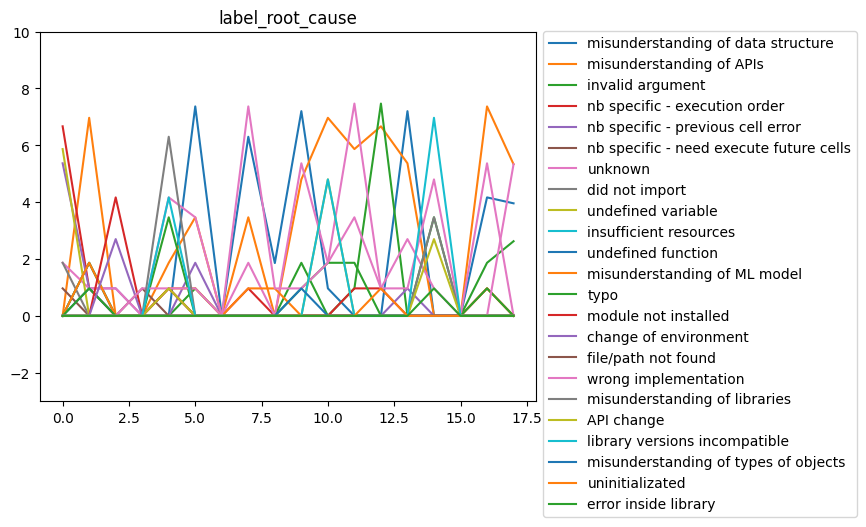

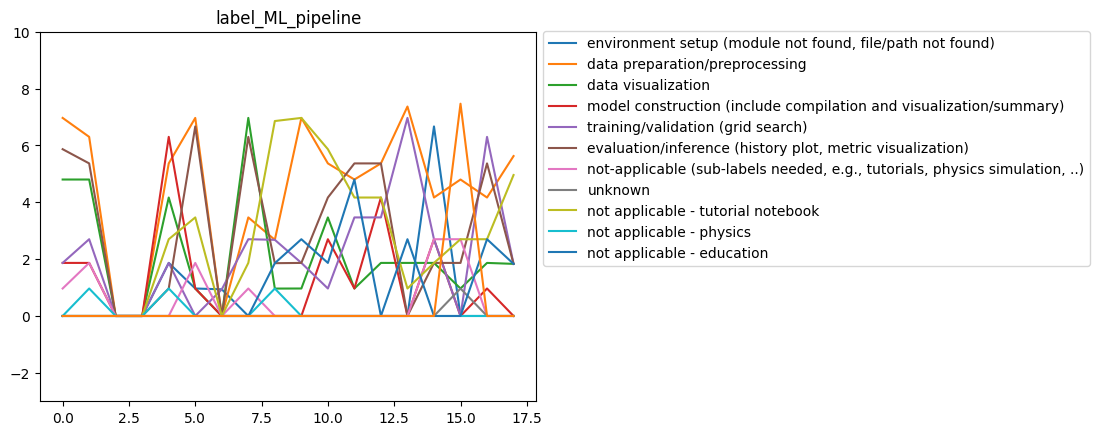

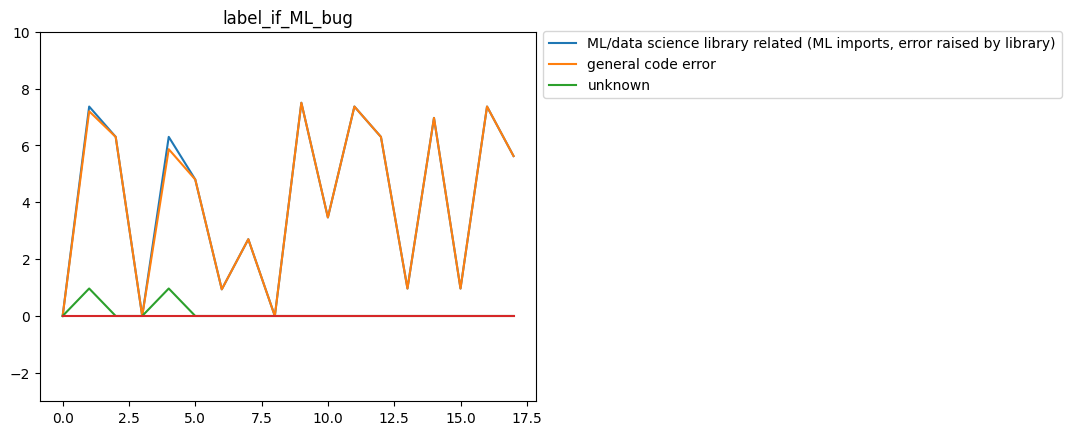

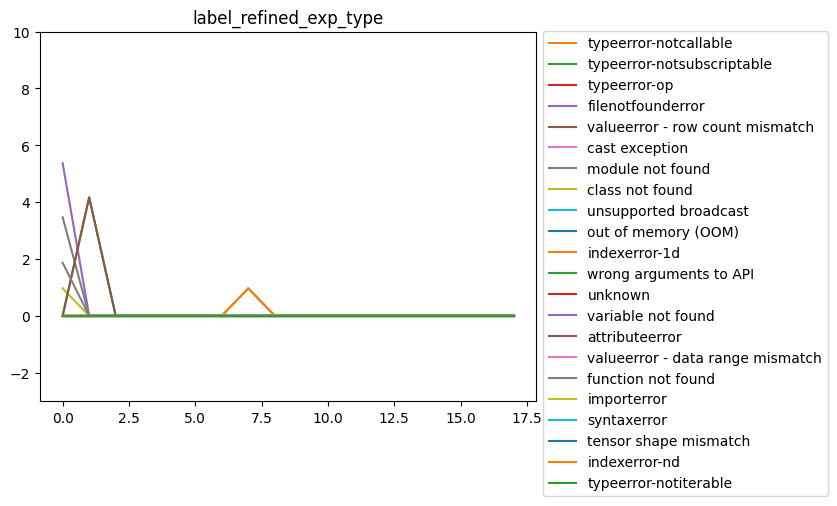

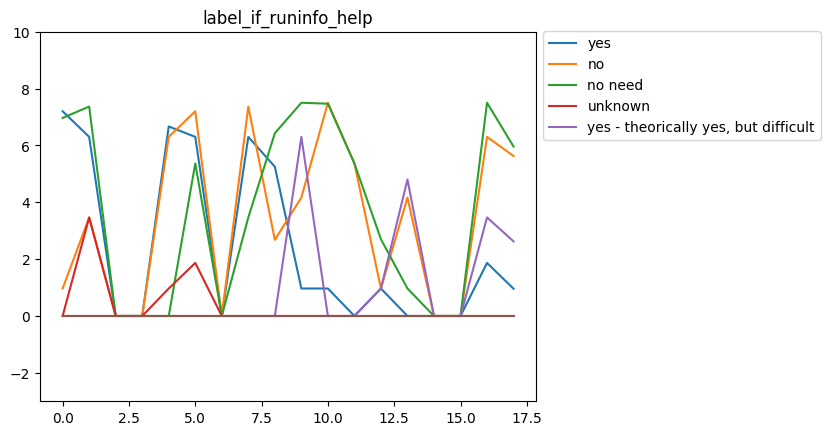

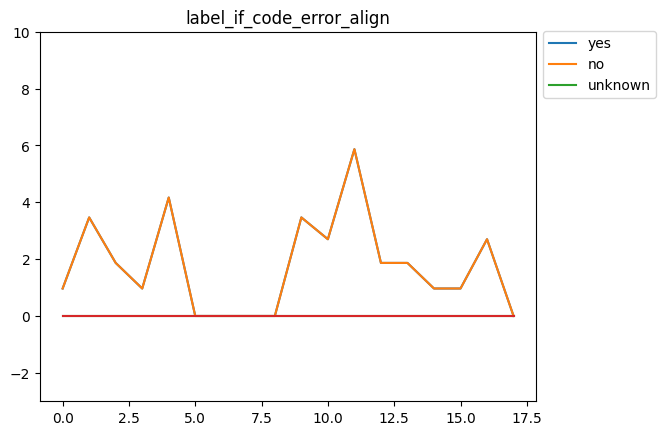

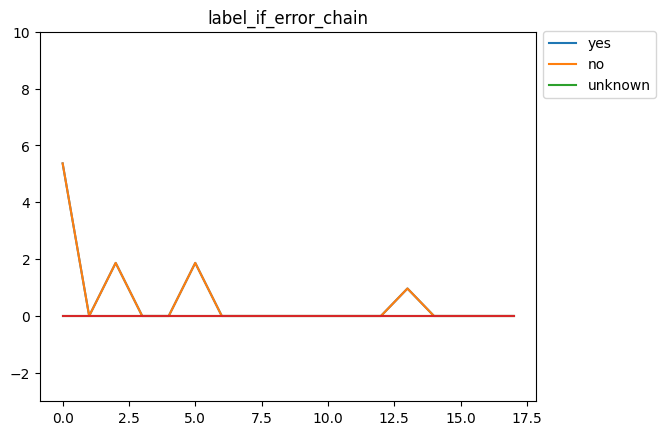

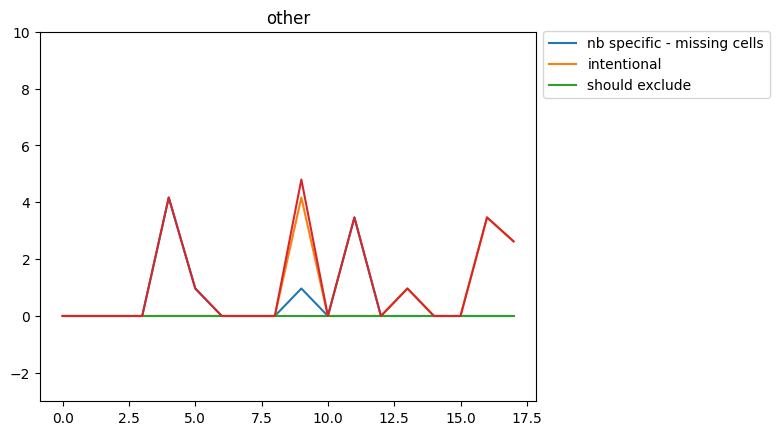

In [35]:
# calculate variances
def var(p, n):
    return n*p*(1-p)

def var_sample(x):
    if isinstance(x, tuple):
        if x[1] > 0:
            return var(x[0]/x[1], x[1])
    return 0

def cal_var(df_mlerr_label_config, cluster_res):
    cluster_res_vars = {}
    for label_key in df_mlerr_label_config:
        cluster_res_var = cluster_res[label_key].iloc[:, 1:].map(var_sample)
        cluster_res_vars[label_key] = cluster_res_var
    return cluster_res_vars

def plot_var_by_config(df_mlerr_label_config, cluster_df):
    for label_key in df_mlerr_label_config:
        ax = cluster_df[label_key].plot(title=label_key, ylim=(-3,10), xlabel=None)
        ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
        plt.show()

cluster_res_all_variances = cal_var(df_mlerr_label_config, cluster_res_all)
plot_var_by_config(df_mlerr_label_config, cluster_res_all_variances)

In [151]:
# sampling

# calculate overall sample size with stratified sampling
# def sample_size(e):
#     nh_n = Nh * np.sqrt(Sh2) / sum(Nl*np.sqrt(Sl2))
#     v = sum(nh_n * (Nh/N)**2 * Sh2)
#     return 1.96**2 * v/e/e
def cal_sample_size(cluster_res_variances, cluster_res, df_mlerr_label_config, config_index=0):
    var_all_ps = cluster_res_variances[df_mlerr_label_config.columns[config_index]]
    ks = var_all_ps.columns
    n_k = len(ks)
    n_h = len(cluster_res[df_mlerr_label_config.columns[config_index]])

    res_n = []
    Nh = np.array([i[1][2] for i in cluster_res[df_mlerr_label_config.columns[config_index]][ks[0]].items()])
    N = sum(Nh)
    for k in ks:
        Sh2 = np.array([i[1] for i in var_all_ps[k].items()]) # Nh*0.5*(1-0.5) #

        with np.errstate(divide='ignore', invalid='ignore'):
            nh_n = np.divide(Nh * np.sqrt(Sh2),sum(Nh*np.sqrt(Sh2)))
            nh_n[nh_n == np.inf] = 0
            nh_n = np.nan_to_num(nh_n)

            v1 = np.divide(1,nh_n)
            v1[v1 == np.inf] = 0
            v1 = np.nan_to_num(v1)

        v = sum(v1 * ((Nh/N)**2) * Sh2)
        e = 0.04
        n = (1.96**2) * v/e/e
        res_n.append(n)

    n = max(np.ceil(res_n))
    
    res_nh = []
    for k in ks:
        Sh2 = np.array([i[1] for i in var_all_ps[k].items()])
        with np.errstate(divide='ignore', invalid='ignore'):
            nh = np.divide(Nh * np.sqrt(Sh2),sum(Nh*np.sqrt(Sh2))) * n
            nh[nh == np.inf] = 0
            nh = np.nan_to_num(nh)
            res_nh.append(nh)
    
    return n, res_nh

In [164]:
config_index = 0
print("Using the category of", df_mlerr_label_config.columns[config_index])
cal_sample_size(cluster_res_all_variances, cluster_res_all, df_mlerr_label_config, config_index=config_index)

Using the category of label_root_cause


(5024.0,
 [array([   0.        , 1942.53948234,    0.        ,    0.        ,
            0.        ,  825.25323403,    0.        ,  523.00020434,
          257.94181431,  448.53799869,  164.12172606,    0.        ,
            0.        ,  424.17451408,    0.        ,    0.        ,
          247.59430491,  190.83672123]),
  array([   0.        , 2440.15915591,    0.        ,    0.        ,
          309.62277899,  368.10942488,    0.        ,  252.26488152,
            0.        ,  238.13475326,  286.48994838,  262.90120702,
          270.0910142 ,  238.12215417,    0.        ,    0.        ,
          214.0676052 ,  144.03707645]),
  array([   0.        , 2874.86010163,    0.        ,    0.        ,
            0.        ,  442.42224787,    0.        ,    0.        ,
            0.        ,  337.99730686,    0.        ,  242.89184665,
          650.57420345,    0.        ,    0.        ,    0.        ,
          245.25988422,  229.99440933]),
  array([4423.8860912 ,  410.35669478,  

### 2.1. GitHub errors

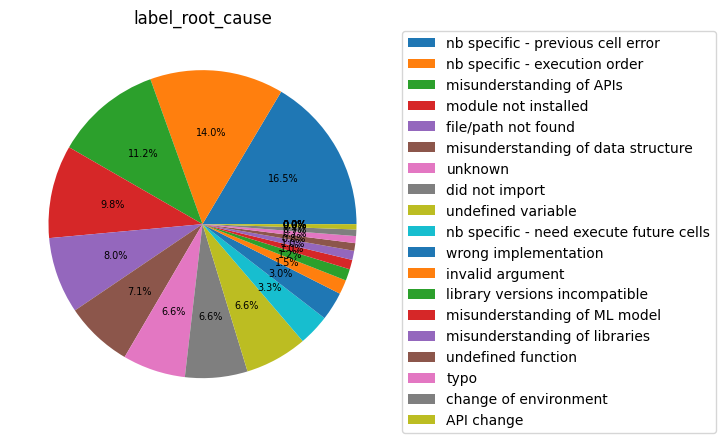

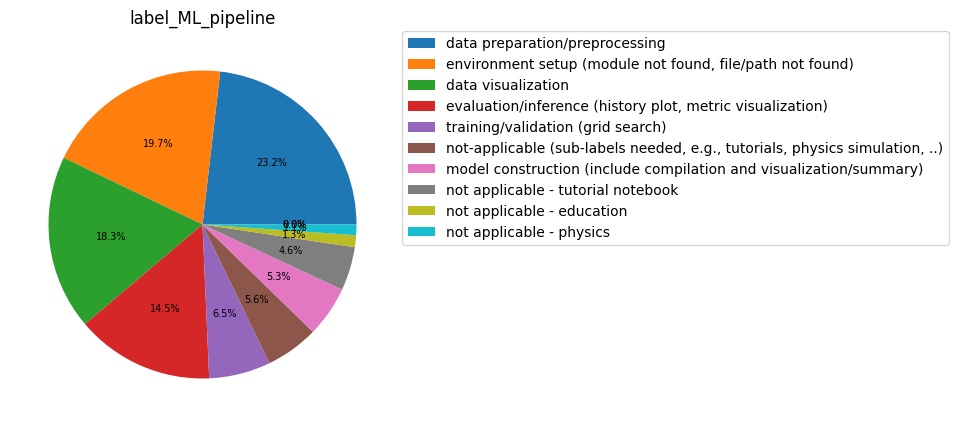

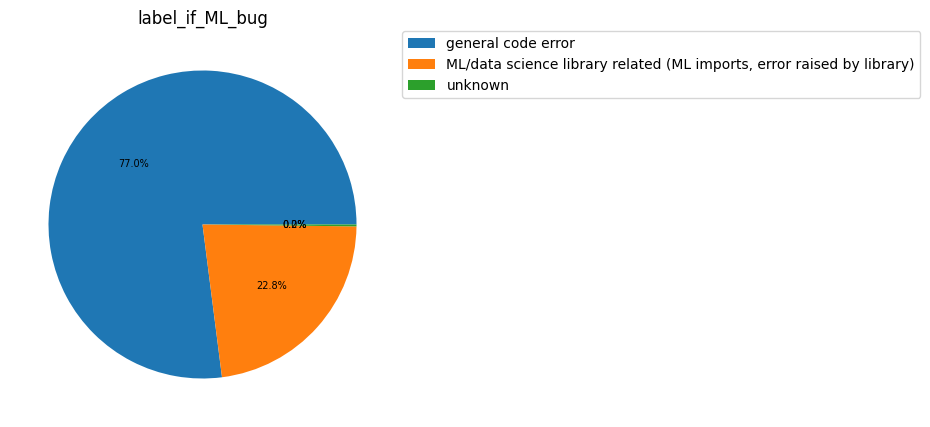

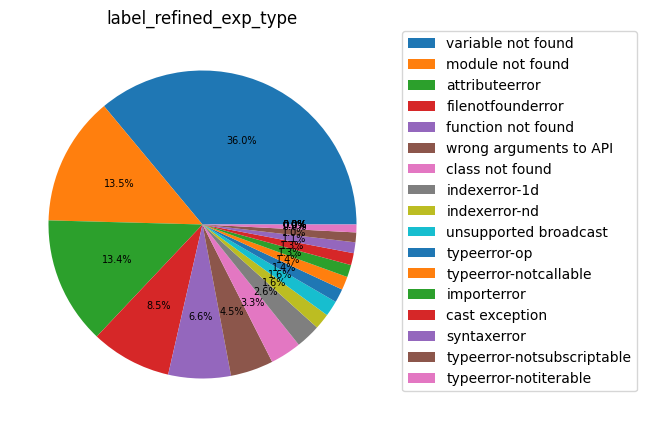

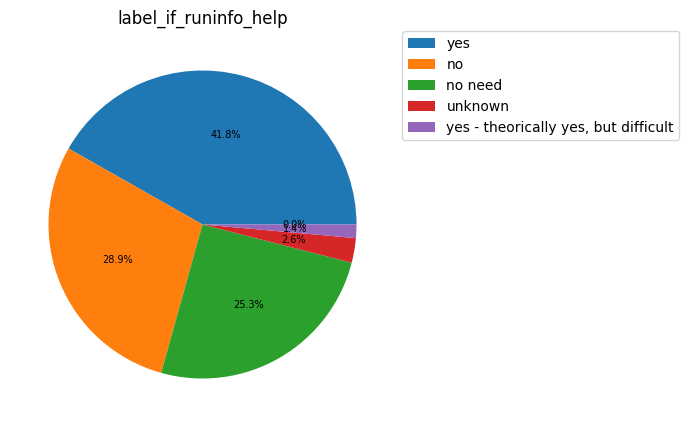

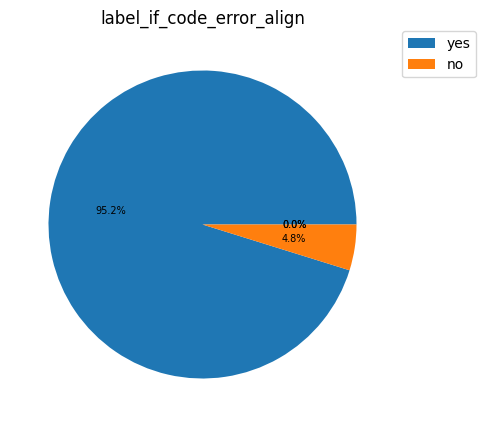

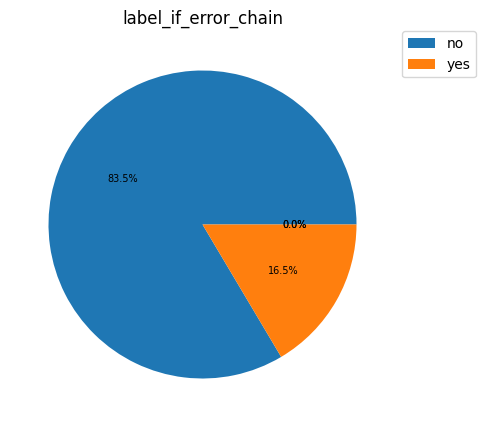

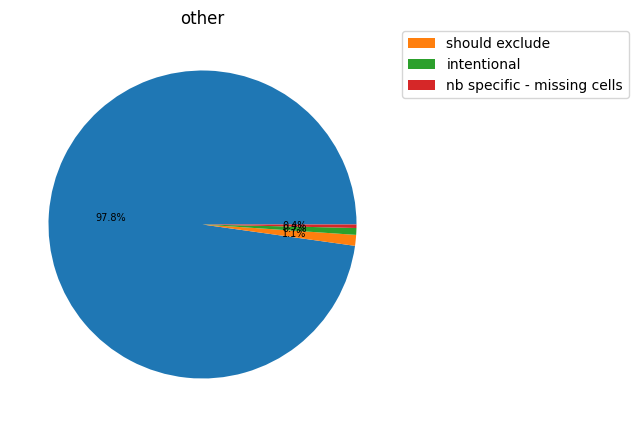

In [16]:
cluster_res_g = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_g.pickle"))
for label_key in df_mlerr_label_config:
    cluster_res_g[label_key] = pd.DataFrame.from_dict(cluster_res_g[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_g_weighted_sum = cal_weighted_sum(df_mlerr_label_config, cluster_res_g)
# cluster_res_g["label_root_cause"].head()
# cluster_res_g_weighted_sum["label_root_cause"]
plot_dist_labels(df_mlerr_label_config, cluster_res_g_weighted_sum)

In [18]:
cluster_res_g_moes = cal_moe(df_mlerr_label_config, cluster_res_g)
display_df_by_config(df_mlerr_label_config, cluster_res_g_moes)

misunderstanding of APIs                   0.341571
misunderstanding of data structure         0.283279
wrong implementation                       0.277186
unknown                                    0.267787
library versions incompatible              0.181685
invalid argument                           0.178525
typo                                       0.152755
nb specific - execution order              0.143138
misunderstanding of libraries              0.141136
API change                                 0.137044
nb specific - previous cell error          0.134952
misunderstanding of ML model               0.089262
module not installed                       0.089262
undefined variable                         0.086015
did not import                             0.086015
undefined function                         0.063118
change of environment                      0.063118
nb specific - need execute future cells    0.063118
file/path not found                        0.063118
insufficient

data preparation/preprocessing                                                 0.422062
not applicable - tutorial notebook                                             0.359432
evaluation/inference (history plot, metric visualization)                      0.308292
data visualization                                                             0.273049
training/validation (grid search)                                              0.266722
not applicable - education                                                     0.232523
not-applicable (sub-labels needed, e.g., tutorials, physics simulation, ..)    0.192336
model construction (include compilation and visualization/summary)             0.184791
environment setup (module not found, file/path not found)                      0.160033
not applicable - physics                                                       0.109324
unknown                                                                        0.000000
                                

ML/data science library related (ML imports, error raised by library)    0.398480
general code error                                                       0.396332
unknown                                                                  0.063118
                                                                         0.000000
dtype: float64

variable not found                  0.111896
wrong arguments to API              0.106689
function not found                  0.086015
attributeerror                      0.086015
module not found                    0.063118
class not found                     0.063118
indexerror-nd                       0.063118
                                    0.000000
unknown                             0.000000
tensor shape mismatch               0.000000
syntaxerror                         0.000000
importerror                         0.000000
valueerror - data range mismatch    0.000000
indexerror-1d                       0.000000
typeerror-notcallable               0.000000
out of memory (OOM)                 0.000000
unsupported broadcast               0.000000
cast exception                      0.000000
valueerror - row count mismatch     0.000000
filenotfounderror                   0.000000
typeerror-op                        0.000000
typeerror-notsubscriptable          0.000000
typeerror-

no need                                 0.382447
no                                      0.353042
yes                                     0.308292
yes - theorically yes, but difficult    0.195273
unknown                                 0.119282
                                        0.000000
dtype: float64

no         0.282272
yes        0.282272
unknown    0.000000
           0.000000
dtype: float64

yes        0.134952
no         0.134952
unknown    0.000000
           0.000000
dtype: float64

                               0.202428
intentional                    0.176924
nb specific - missing cells    0.109324
should exclude                 0.000000
dtype: float64

### 2.2. Kaggle errors

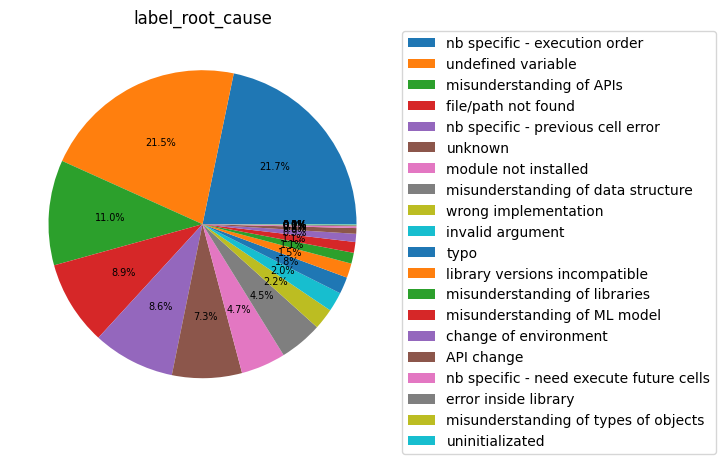

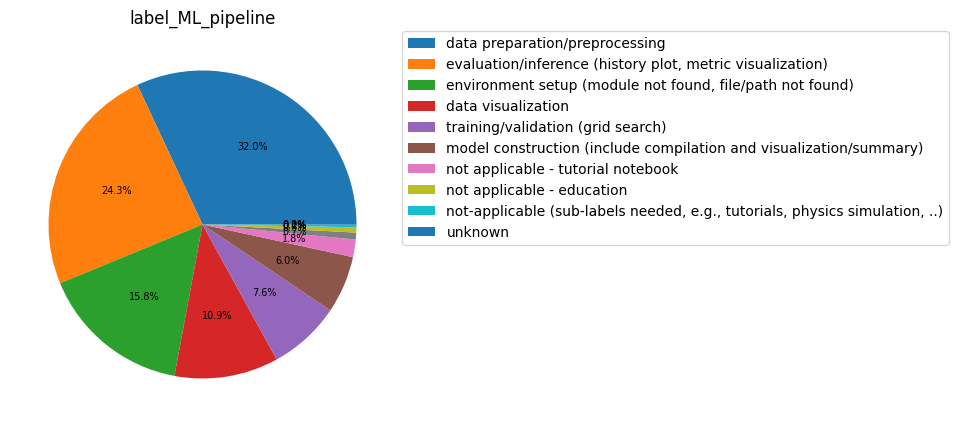

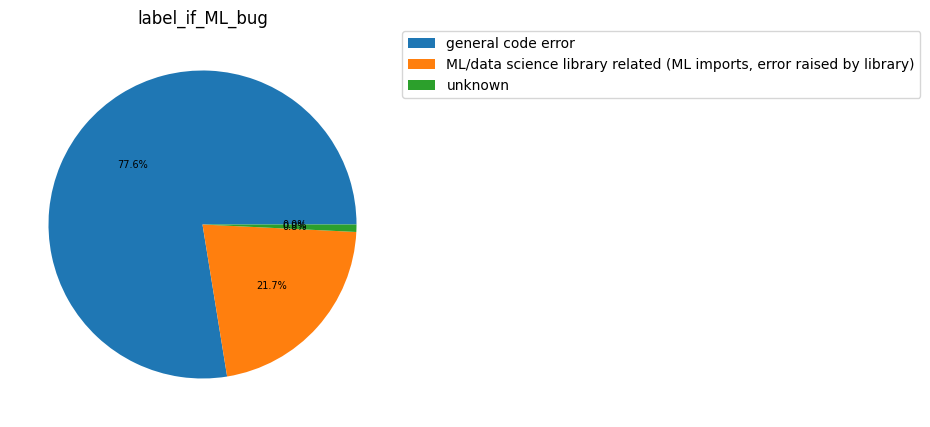

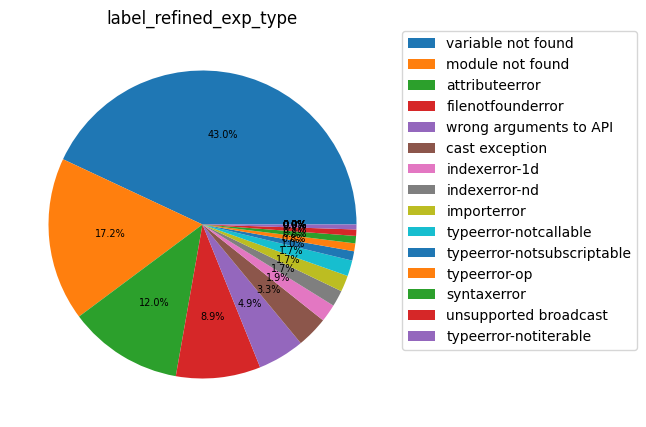

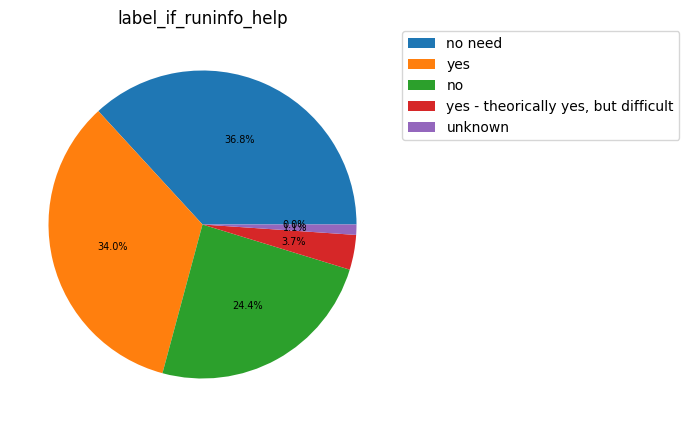

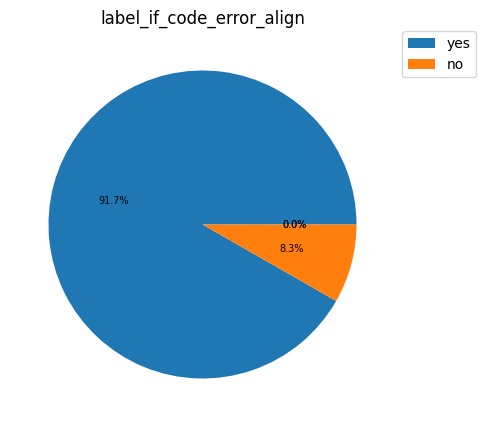

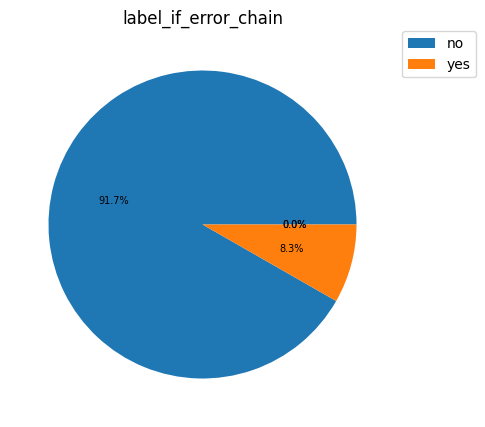

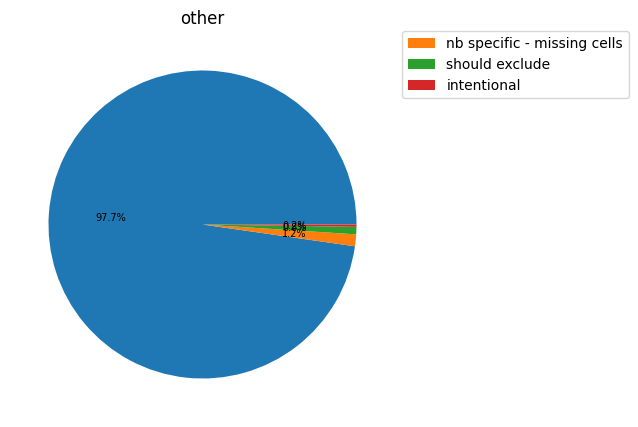

In [19]:
cluster_res_k = load_statistics(config.path_default.joinpath("data_dedup_cluster/sample2_statistics_k.pickle"))
for label_key in df_mlerr_label_config:
    cluster_res_k[label_key] = pd.DataFrame.from_dict(cluster_res_k[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_k_weighted_sum = cal_weighted_sum(df_mlerr_label_config, cluster_res_k)
# cluster_res_k["label_root_cause"].head()
# cluster_res_k_weighted_sum["label_root_cause"]
plot_dist_labels(df_mlerr_label_config, cluster_res_k_weighted_sum)

In [20]:
cluster_res_k_moes = cal_moe(df_mlerr_label_config, cluster_res_k)
display_df_by_config(df_mlerr_label_config, cluster_res_k_moes)

misunderstanding of APIs                   0.372874
misunderstanding of data structure         0.320851
unknown                                    0.263502
wrong implementation                       0.262861
typo                                       0.183244
invalid argument                           0.178525
library versions incompatible              0.175308
nb specific - execution order              0.165282
nb specific - previous cell error          0.150881
misunderstanding of libraries              0.147060
misunderstanding of ML model               0.145538
API change                                 0.128470
undefined variable                         0.123961
module not installed                       0.111896
change of environment                      0.086015
nb specific - need execute future cells    0.063118
misunderstanding of types of objects       0.063118
uninitializated                            0.063118
error inside library                       0.063118
undefined fu

data preparation/preprocessing                                                 0.396700
evaluation/inference (history plot, metric visualization)                      0.370670
training/validation (grid search)                                              0.315063
not applicable - tutorial notebook                                             0.288387
data visualization                                                             0.281262
model construction (include compilation and visualization/summary)             0.239753
not applicable - education                                                     0.141136
environment setup (module not found, file/path not found)                      0.119282
not-applicable (sub-labels needed, e.g., tutorials, physics simulation, ..)    0.089262
unknown                                                                        0.063118
                                                                               0.063118
not applicable - physics        

ML/data science library related (ML imports, error raised by library)    0.378346
general code error                                                       0.376839
unknown                                                                  0.063118
                                                                         0.000000
dtype: float64

wrong arguments to API              0.101214
module not found                    0.101214
attributeerror                      0.101214
variable not found                  0.101214
                                    0.000000
indexerror-nd                       0.000000
tensor shape mismatch               0.000000
syntaxerror                         0.000000
importerror                         0.000000
function not found                  0.000000
valueerror - data range mismatch    0.000000
unknown                             0.000000
indexerror-1d                       0.000000
typeerror-notcallable               0.000000
out of memory (OOM)                 0.000000
unsupported broadcast               0.000000
class not found                     0.000000
cast exception                      0.000000
valueerror - row count mismatch     0.000000
filenotfounderror                   0.000000
typeerror-op                        0.000000
typeerror-notsubscriptable          0.000000
typeerror-

no need                                 0.384961
no                                      0.364726
yes                                     0.292813
yes - theorically yes, but difficult    0.219177
unknown                                 0.109324
                                        0.000000
dtype: float64

no         0.228822
yes        0.228822
unknown    0.000000
           0.000000
dtype: float64

yes        0.148983
no         0.148983
unknown    0.000000
           0.000000
dtype: float64

                               0.215393
nb specific - missing cells    0.156437
intentional                    0.148060
should exclude                 0.000000
dtype: float64

In [21]:
cluster_res_k["label_root_cause"]

,cluster_id,misunderstanding of data structure,misunderstanding of APIs,invalid argument,nb specific - execution order,nb specific - previous cell error,nb specific - need execute future cells,unknown,did not import,undefined variable,...,module not installed,change of environment,file/path not found,wrong implementation,misunderstanding of libraries,API change,library versions incompatible,misunderstanding of types of objects,uninitializated,error inside library
0,1431,"(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(6, 15, 1042)","(2, 15, 1042)","(0, 15, 1042)","(1, 15, 1042)","(0, 15, 1042)","(6, 15, 1042)",...,"(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)","(0, 15, 1042)"
1,273,"(0, 15, 225)","(9, 15, 225)","(2, 15, 225)","(0, 15, 225)","(1, 15, 225)","(0, 15, 225)","(1, 15, 225)","(0, 15, 225)","(0, 15, 225)",...,"(0, 15, 225)","(0, 15, 225)","(0, 15, 225)","(0, 15, 225)","(0, 15, 225)","(0, 15, 225)","(0, 15, 225)","(0, 15, 225)","(0, 15, 225)","(0, 15, 225)"
2,20,"(0, 15, 124)","(0, 15, 124)","(0, 15, 124)","(0, 15, 124)","(1, 15, 124)","(0, 15, 124)","(1, 15, 124)","(0, 15, 124)","(0, 15, 124)",...,"(11, 15, 124)","(2, 15, 124)","(0, 15, 124)","(0, 15, 124)","(0, 15, 124)","(0, 15, 124)","(0, 15, 124)","(0, 15, 124)","(0, 15, 124)","(0, 15, 124)"
3,9,"(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)",...,"(0, 15, 172)","(0, 15, 172)","(15, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)","(0, 15, 172)"
4,7430,"(0, 15, 53)","(2, 15, 53)","(0, 15, 53)","(0, 15, 53)","(0, 15, 53)","(1, 15, 53)","(2, 15, 53)","(0, 15, 53)","(0, 15, 53)",...,"(0, 15, 53)","(0, 15, 53)","(0, 15, 53)","(1, 15, 53)","(5, 15, 53)","(0, 15, 53)","(2, 15, 53)","(0, 15, 53)","(0, 15, 53)","(0, 15, 53)"
5,268,"(6, 15, 36)","(2, 15, 36)","(1, 15, 36)","(0, 15, 36)","(2, 15, 36)","(0, 15, 36)","(3, 15, 36)","(0, 15, 36)","(0, 15, 36)",...,"(0, 15, 36)","(0, 15, 36)","(0, 15, 36)","(0, 15, 36)","(0, 15, 36)","(0, 15, 36)","(0, 15, 36)","(0, 15, 36)","(0, 15, 36)","(0, 15, 36)"
6,3331,"(5, 15, 33)","(1, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)",...,"(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(8, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)","(0, 15, 33)"
7,2255,"(12, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)",...,"(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)","(0, 13, 13)"
8,5224,"(7, 15, 16)","(2, 15, 16)","(1, 15, 16)","(0, 15, 16)","(0, 15, 16)","(0, 15, 16)","(2, 15, 16)","(0, 15, 16)","(0, 15, 16)",...,"(0, 15, 16)","(0, 15, 16)","(0, 15, 16)","(1, 15, 16)","(0, 15, 16)","(0, 15, 16)","(0, 15, 16)","(1, 15, 16)","(0, 15, 16)","(0, 15, 16)"
9,53,"(0, 15, 35)","(5, 15, 35)","(0, 15, 35)","(0, 15, 35)","(0, 15, 35)","(0, 15, 35)","(1, 15, 35)","(0, 15, 35)","(0, 15, 35)",...,"(0, 15, 35)","(0, 15, 35)","(0, 15, 35)","(2, 15, 35)","(0, 15, 35)","(4, 15, 35)","(2, 15, 35)","(0, 15, 35)","(0, 15, 35)","(0, 15, 35)"
